In [3]:
import pandas as pd
import numpy as np

from sklearn import cluster, metrics

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier

from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist

import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('ggplot') 

## 1. Format the Data

In [4]:
ap = pd.read_csv('https://www.dropbox.com/s/gkz6ujexqsneefl/airport2.csv?dl=1')
ap.head()

,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions
0,ABQ,2004,242,235,71,46
1,ABQ,2005,221,190,61,33
2,ABQ,2006,392,329,71,124
3,ABQ,2007,366,304,107,45
4,ABQ,2008,333,300,79,42


Convert the class labels, in this case the airports, to numeric. *Remember*, we've truncated the airport dataset for simplicty to make this part easy! 

In [5]:
def air_to_numeric(x):
    if x=='ABQ':
        return 0
    if x=='ANC':
        return 1
    if x=='ATL':
        return 2

In [6]:
ap['Airport'] = ap['Airport'].apply(air_to_numeric)

## 2. Plot the data

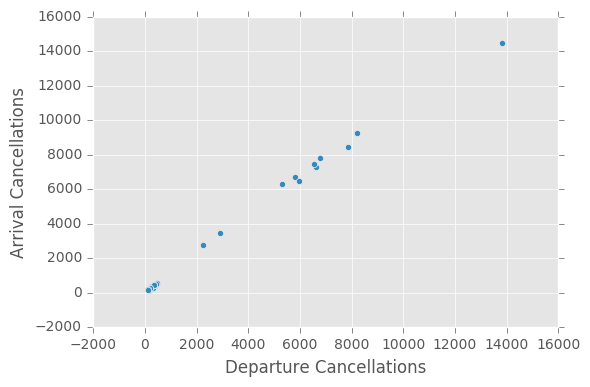

In [7]:
ap.plot(kind='scatter', x='Departure Cancellations', y='Arrival Cancellations')

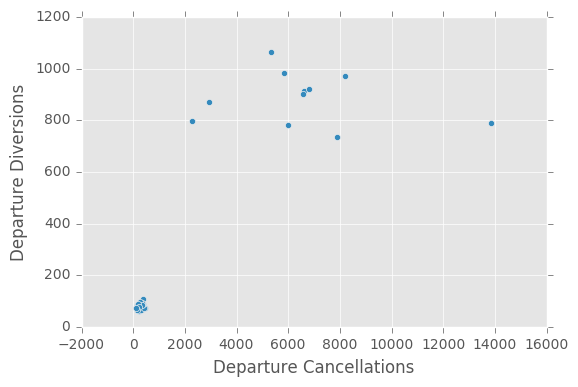

In [8]:
ap.plot(kind='scatter', x='Departure Cancellations', y='Departure Diversions')

**Question**: Based on the graphs, how many clusters do you estimate that we have?

## 3.  Perform a K-Means Clustering 

#### 3.1 Split the dataset into the attribute data and class labels

In [9]:
X = ap.ix[:,1:5].as_matrix(columns=None)
y = ap.ix[:,0]

In [10]:
X

array([[ 2004,   242,   235,    71],
       [ 2005,   221,   190,    61],
       [ 2006,   392,   329,    71],
       [ 2007,   366,   304,   107],
       [ 2008,   333,   300,    79],
       [ 2009,   192,   162,    74],
       [ 2010,   222,   177,    71],
       [ 2011,   345,   294,    77],
       [ 2012,   237,   181,    65],
       [ 2013,   232,   212,    62],
       [ 2014,   315,   274,    66],
       [ 2004,   473,   532,    73],
       [ 2005,   424,   484,    74],
       [ 2006,   367,   436,    88],
       [ 2007,   359,   423,    93],
       [ 2008,   268,   355,    97],
       [ 2009,   354,   421,    84],
       [ 2010,   149,   204,    84],
       [ 2011,   191,   265,    87],
       [ 2012,   216,   284,    78],
       [ 2013,   141,   184,    65],
       [ 2014,   111,   162,    74],
       [ 2004,  7870,  8433,   737],
       [ 2005, 13837, 14480,   790],
       [ 2006,  6624,  7301,   913],
       [ 2007,  6796,  7790,   920],
       [ 2008,  5830,  6705,   982],
 

#### 3.2 Conduct the k-means clustering

In [62]:
k = 3
kmeans = cluster.KMeans(n_clusters=k)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

#### 3.3 Compute the labels and centroids

In [86]:
clusters = kmeans.labels_
centroids = kmeans.cluster_centers_

In [87]:
from scipy import stats
labels = np.zeros_like(clusters)
for i in range(k):
    mask = (clusters == i)
    labels[mask] = stats.mode(y[mask])[0]

In [88]:
print(labels)
print(centroids)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 2]
[[  2009.29166667    471.875         526.66666667    140.375     ]
 [  2005.          13837.          14480.            790.        ]
 [  2008.625        6646.75         7472.25          908.875     ]]


#### 3.4 Format the resulting predicted "y" variables and check the accuracy score, classification report, and confusion matrix

In [89]:
metrics.accuracy_score(y, labels)

0.60606060606060608

In [90]:
print(metrics.classification_report(y, labels))

             precision    recall  f1-score   support

          0       0.46      1.00      0.63        11
          1       0.00      0.00      0.00        11
          2       1.00      0.82      0.90        11

avg / total       0.49      0.61      0.51        33



In [91]:
print(metrics.confusion_matrix(y, labels))

[[11  0  0]
 [11  0  0]
 [ 2  0  9]]


**Question**: What are we understand from this these performance metrics? 

## 4. Extra Trees Classifier

In [92]:
trees = ExtraTreesClassifier()
trees.fit(X, labels)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [93]:
print(trees.feature_importances_)

[ 0.03900463  0.28241987  0.56240079  0.1161747 ]


## 5. KNN Classifier

In [94]:
knn = KNeighborsClassifier()
knn.fit(X, labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [95]:
exp = labels
predicted = knn.predict(x)

In [96]:
print(metrics.classification_report(exp, predicted))
print(metrics.confusion_matrix(exp, predicted))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        24
          2       1.00      1.00      1.00         9

avg / total       1.00      1.00      1.00        33

[[24  0]
 [ 0  9]]


## 6. Hierarchical Clustering

#### 1. Create the linkage for clustering

In [97]:
Z = linkage(X, 'ward')

In [98]:
c, coph_dists = cophenet(Z, pdist(X))
c

0.88957255706074634

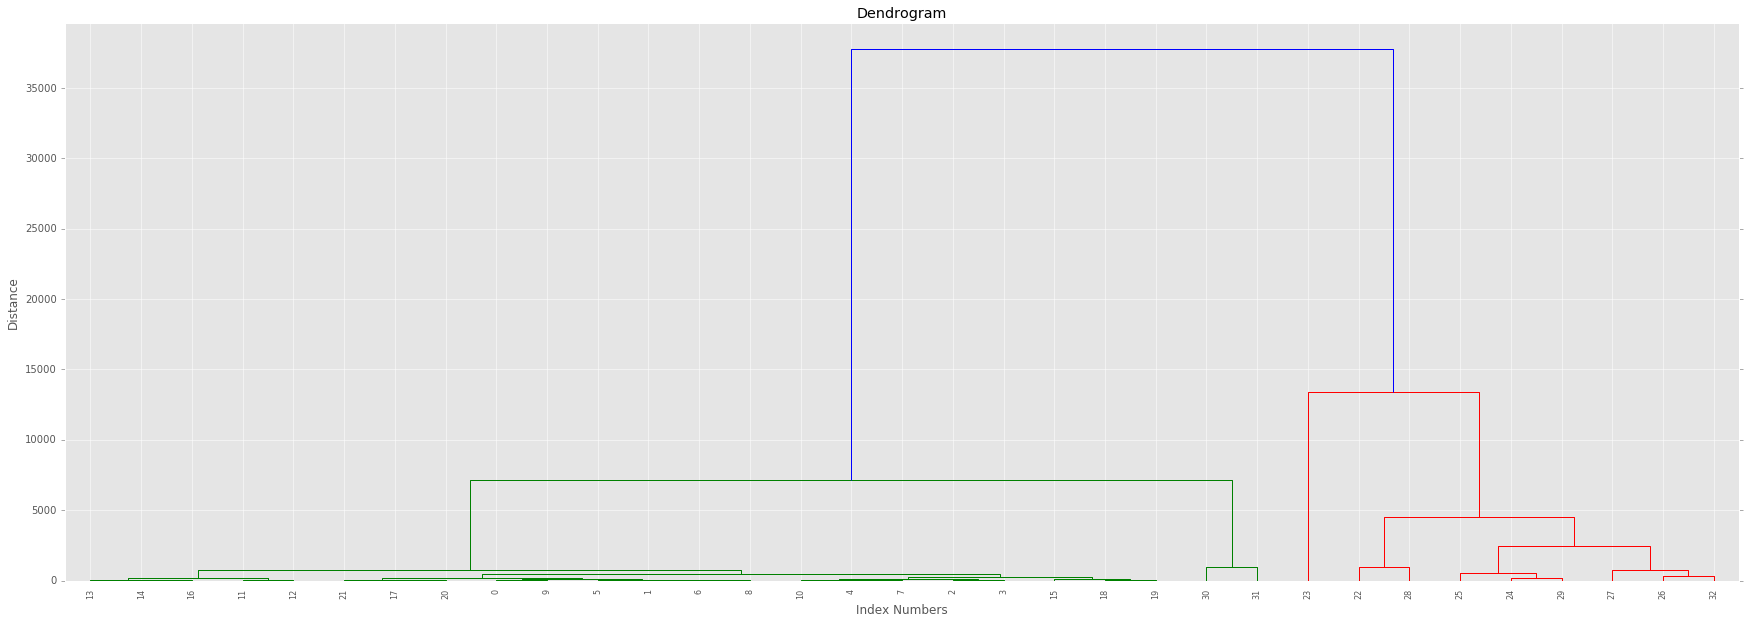

In [99]:
plt.figure(figsize=(30, 10))
plt.title('Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    leaf_rotation=90.,  
    leaf_font_size=8.,
)
plt.show()

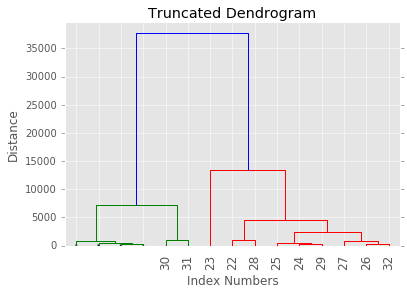

In [100]:
plt.title('Truncated Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    truncate_mode='lastp',  
    p=15,  
    show_leaf_counts=False,  
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  
)
plt.show()

In [101]:
max_d = 30
clusters = fcluster(Z, max_d, criterion='distance')
clusters

array([ 6,  7, 11, 12,  9,  8,  7,  9,  7,  6, 10,  2,  3,  1,  1, 15,  1,
        4, 13, 14,  4,  5, 18, 26, 20, 22, 23, 25, 19, 21, 16, 17, 24], dtype=int32)

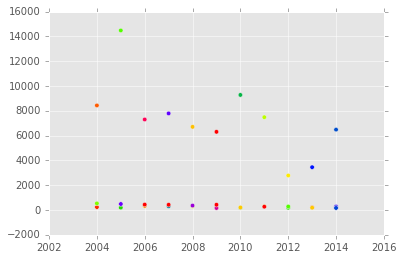

In [102]:
plt.scatter(X[:,0], X[:,2], c=clusters, cmap='prism')
plt.show()

## Extra Trees Classifier

In [103]:
trees2 = ExtraTreesClassifier()
trees2.fit(X, clusters)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [104]:
print(trees2.feature_importances_)

[ 0.16703493  0.267451    0.32247732  0.24303675]


## KNN Classifier

In [105]:
knn2 = KNeighborsClassifier()
knn2.fit(X, clusters)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [106]:
exp2 = clusters
predicted2 = knn2.predict(X)

In [107]:
print(metrics.classification_report(exp, predicted))
print(metrics.confusion_matrix(exp, predicted))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        24
          2       1.00      1.00      1.00         9

avg / total       1.00      1.00      1.00        33

[[24  0]
 [ 0  9]]
